# PDE Solving

In this notebook, we look at how the methods for computing eigenfunctions perform when applied to the problem of solving the PDE
$$\partial_t u + \mathcal{L}u = 0, \quad u(\cdot,0) = f$$

We note that $-\mathcal{L}$ is the generator of LD, so that if $(X_t)$ is the stochastic process defined through
$$X_t = -\nabla E(X_t) dt + \sqrt{2}\ dW_t$$
then the quantity $u(x,t) = \mathbb{E}[f(X_t) | X_0 = x]$ satisfies the PDE above.

In [59]:
import sys
import os
project_root = os.path.abspath("..")  # If notebooks is one folder above src, change accordingly.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import seaborn as sns
import numpy as np
import pandas as pd
import ipywidgets as widgets
import torch
import torch.optim as optim
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from tqdm import tqdm

from src.energy.quadratic import QuadraticEnergy
from src.energy.GMM import GaussianMixture

from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver

from src.eigensolver.neural.neural_eigensolver import NeuralSolver
from src.eigensolver.neural.network.feedforward import ConstantFFN

from src.pdesolver.exact_solver import ExactEigenSolver
from src.pdesolver.fitted_solver import FittedEigenSolver

from src.sampler.langevinsampler import LangevinSampler



## One-dimensional

### Gaussian

In this example, we look at the performance of the eigenfunction method for approximating $u(x,t)$ as described above for $E = \frac{1}{2}x^2$ and various functions $f$.

In [7]:
dim = 1

energy = QuadraticEnergy(torch.eye(dim))

The <code>LangevinSampler</code> class can be used to sample trajectories:

In [12]:
sampler = LangevinSampler(energy)

N = 50000
x = torch.zeros((N,dim))

T = 2
num_steps = 20000

samples = sampler.simulate_full(x, T, num_steps)

100%|██████████| 20000/20000 [00:57<00:00, 348.68it/s] 


Text(0.5, 1.0, 'Trajectories of LD')

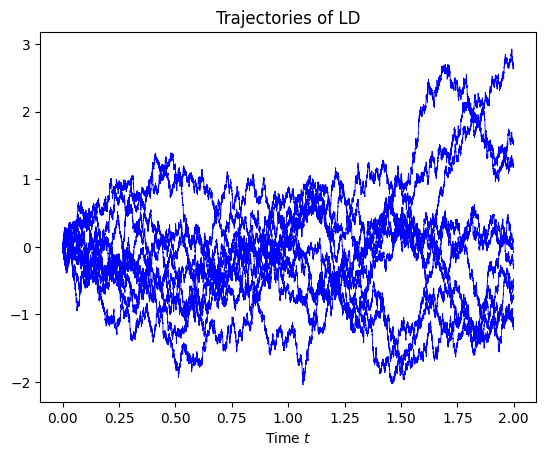

In [13]:
t = torch.linspace(0,T,num_steps+1)

plt.plot(t,samples[:,:10,0], color = 'blue', lw = 0.6, ls = '-')
plt.xlabel('Time $t$')
plt.title('Trajectories of LD')

We consider here how the variance evolves over time, as well as some other function (feel free to edit)

In [14]:
def func_1(x):
    return x[0]**2

def func_2(x):
    return torch.where(torch.abs(x[0])<1,1.0,0.0)

Text(0.5, 1.0, 'Custom function')

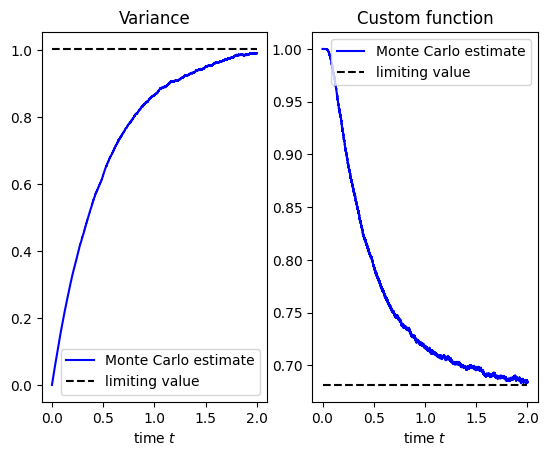

In [ ]:
fig, ax = plt.subplots(1,2)
funcs = [func_1,func_2]
func_names = ['variance', 'custom_func']

for i, func in enumerate(funcs):
    batched_func = torch.vmap(func)
    double_batched_func = torch.vmap(batched_func)

    fsamples = double_batched_func(samples)

    mean_f = fsamples.mean(dim=1)
    limiting_value = batched_func(energy.exact_sample((100000,))).mean()

    ax[i].plot(t,mean_f, color = 'blue', label = 'Monte Carlo estimate')
    ax[i].hlines(limiting_value,0,T, color = 'black', ls = '--', label = 'limiting value')
    ax[i].set_xlabel('time $t$')
    ax[i].legend()
    ax[i].set_title(func_names[i])

To solve the PDE using exact or fitted eigenfunctions, we can use the <code>PDESolver</code> class. It is based on the fact that if $(\phi_i,\lambda_i)$ is the eigensystem of $\mathcal{L}$, it holds that the solution to the PDE
$$\partial_t u + \mathcal{L}u = 0 ,\qquad u(0) = f$$
is given by
$$u(x,t) = \sum_{i=1}^\infty e^{-\lambda_i t} <f, \phi_i>_\mu \phi_i(x)

In [16]:
x = energy.exact_sample((100000,))

kernel_params = {
    'dim': 1,
    'scale': 2.0,
}

k = 10
p = 100
kernel = GaussianKernel(kernel_params)

basis_points = energy.exact_sample((p,))
basis = KernelBasis(kernel, basis_points)
basis = ConstantBasis(basis)

solver_params = {
    'verbose': True,
    'num_samples': 10000
}

solver = GalerkinSolver(energy, x, solver_params)

solver = solver.fit(basis,k=min(p-1,k),L_reg=1e-6)

In [17]:
fitted_solver = FittedEigenSolver(energy, x, solver)
exact_solver = ExactEigenSolver(energy, x)

Text(0.5, 1.0, 'Custom function')

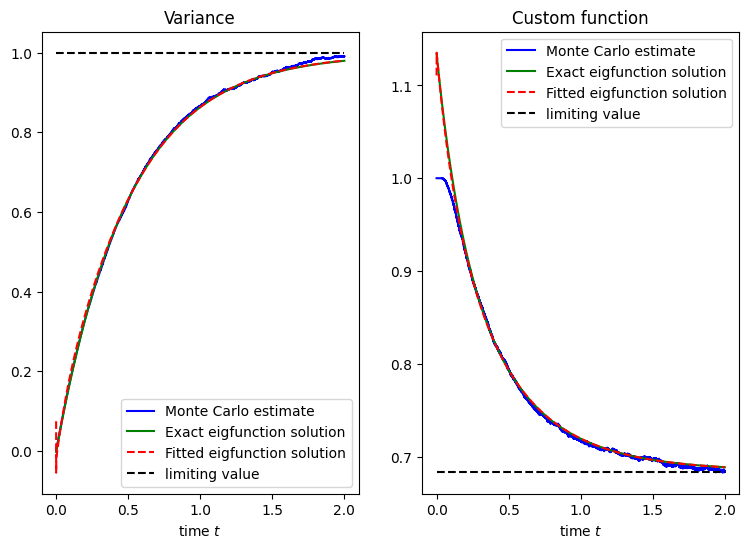

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,6))

for i, func in enumerate(funcs):
    batched_func = torch.vmap(func)
    double_batched_func = torch.vmap(batched_func)

    fsamples = double_batched_func(samples)

    mean_f = fsamples.mean(dim=1)
    limiting_value = batched_func(energy.exact_sample((100000,))).mean()
    point = torch.zeros((1,1))

    exact_sol = exact_solver.solve(batched_func, t, point, k)[0]
    fitted_sol = fitted_solver.solve(batched_func, t, point, k)[-1][0]

    ax[i].plot(t,mean_f, color = 'blue', label = 'Monte Carlo estimate')

    ax[i].plot(t,exact_sol, color = 'green', label = 'Exact eigfunction solution')
    ax[i].plot(t,fitted_sol, color = 'red', label = 'Fitted eigfunction solution', ls = '--')

    ax[i].hlines(limiting_value,0,T, color = 'black', ls = '--', label = 'limiting value')
    ax[i].set_xlabel('time $t$')
    ax[i].legend()
    ax[i].set_title(func_names[i])

### Gaussian Mixture

We can try to do the same thing for a more complicated energy function (although we then no longer have access to the exact eigenfunctions).

In [77]:
dim = 1

weights = torch.tensor([0.9,0.1])
means = torch.tensor([[0],[4.0]])
covs = torch.ones([2,1,1])

energy = GaussianMixture(weights, means, covs)

(-1.0, 5.0)

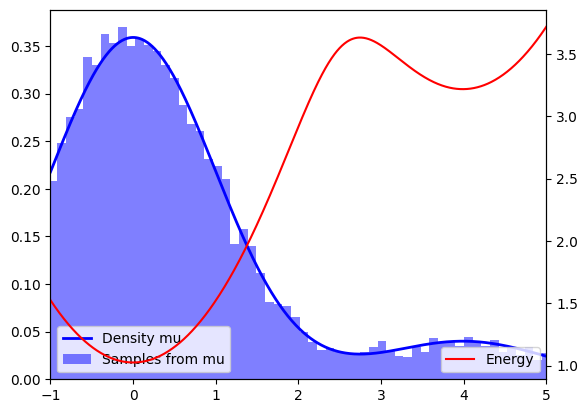

In [78]:
x = torch.linspace(-1,5,1000).unsqueeze(1)
plt.plot(x, torch.exp(-energy.forward(x)), label = "Density mu", color = 'blue', lw = 2)
plt.hist(energy.exact_sample((10000,)),bins=100,density=True, label = "Samples from mu",color="blue",alpha=.5)
plt.legend(loc = "lower left")
plt.twinx()
plt.plot(x, energy.forward(x), label = "Energy",color='red')
plt.legend(loc = "lower right")
plt.xlim(x.min(),x.max())

We will attempt to answer the following questions. If we start in the right-side minimum ($x=4$),
1) What is the expected squared deviation from $x=4$ and $x=0$ at time $t$?
$$\mathbb{E}[(X_t-4)^2 | X_0 = 4] \text{ and } \mathbb{E}[X_t^2 | X_0 = 4]$$
2) What is the probability that we are far to the left at time $t$?
$$\mathbb{E}[1_{X_t < -1} | X_0 = 4]$$

In [79]:
sampler = LangevinSampler(energy)

In [102]:
N = 10000
x = torch.ones((N,dim))*4

T = 5
num_steps = 50000*T

samples = sampler.simulate_full(x, T, num_steps)

100%|██████████| 250000/250000 [06:55<00:00, 601.02it/s]


Text(0.5, 1.0, 'Trajectories of LD')

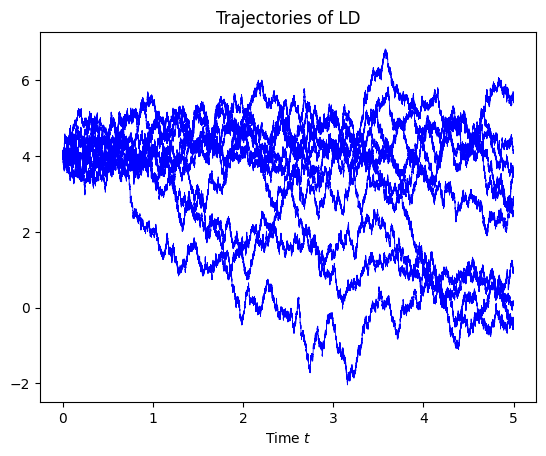

In [179]:
t = torch.linspace(0,T,num_steps+1)

plt.plot(t,samples[:,:10,0], color = 'blue', lw = 0.6, ls = '-')
plt.xlabel('Time $t$')
plt.title('Trajectories of LD')

In [197]:
def func_1(x):
    return (x[0]-4)**2

def func_2(x):
    return (x[0])**2

def func_3(x):
    return torch.where(x[0] < -1, 1.0, 0.0)

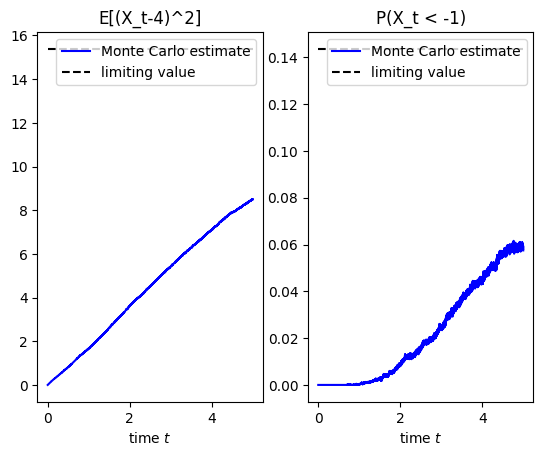

In [198]:
fig, ax = plt.subplots(1,2)
funcs = [func_1,func_2]
func_names = ['E[(X_t-4)^2]', 'P(X_t < -1)']

for i, func in enumerate(funcs):
    batched_func = torch.vmap(func)
    double_batched_func = torch.vmap(batched_func)

    fsamples = double_batched_func(samples)

    mean_f = fsamples.mean(dim=1)
    limiting_value = batched_func(energy.exact_sample((100000,))).mean()

    ax[i].plot(t,mean_f, color = 'blue', label = 'Monte Carlo estimate')
    ax[i].hlines(limiting_value,0,T, color = 'black', ls = '--', label = 'limiting value')
    ax[i].set_xlabel('time $t$')
    ax[i].legend()
    ax[i].set_title(func_names[i])

To solve the PDE using exact or fitted eigenfunctions, we can use the <code>PDESolver</code> class. It is based on the fact that if $(\phi_i,\lambda_i)$ is the eigensystem of $\mathcal{L}$, it holds that the solution to the PDE
$$\partial_t u + \mathcal{L}u = 0 ,\qquad u(0) = f$$
is given by
$$u(x,t) = \sum_{i=1}^\infty e^{-\lambda_i t} <f, \phi_i>_\mu \phi_i(x)

In [201]:
x = energy.exact_sample((100000,))

kernel_params = {
    'dim': 1,
    'scale': 1.5,
}

k = 7
p = 100
kernel = GaussianKernel(kernel_params)

basis_points = energy.exact_sample((p,))
basis = KernelBasis(kernel, basis_points)
basis = ConstantBasis(basis)

solver_params = {
    'verbose': True,
    'num_samples': 10000
}

solver = GalerkinSolver(energy, x, solver_params)

solver = solver.fit(basis,k=min(p-1,k),L_reg=1e-6)
fitted_kernel_solver = FittedEigenSolver(energy, x, solver)

In [209]:
model = ConstantFFN([dim,200,200,k])

optimizer = optim.Adam(model.parameters(), lr = 1.0)

from torch.optim.lr_scheduler import LambdaLR

def combined_scheduler(step, warmup_steps, total_steps, max_lr):
    if step < warmup_steps:
        return max_lr * step / warmup_steps  # Linear warmup
    # Cosine decay after warmup
    progress = (step - warmup_steps) / (total_steps - warmup_steps)
    return max_lr / 2 * (1 + np.cos(np.pi * progress))

warmup_steps = 15
num_epochs = 50
max_lr = 5e-3

scheduler = LambdaLR(optimizer, lr_lambda=lambda step: combined_scheduler(step, warmup_steps, num_epochs, max_lr))

x = energy.exact_sample((1000000,))

params = {
    'dim': dim,
    'k': k,
    'beta': 0.4,
    'batch_size': 10000,
    'device': 'cuda:1',
    'num_samples': 100000,
}

solver = NeuralSolver(energy, x, model, optimizer, params, scheduler=scheduler)

progress_bar = tqdm(range(num_epochs), desc=f"Training: ", leave=True)

losses = torch.zeros(num_epochs)
for epoch in progress_bar:
    loss = solver.train_epoch()

    solver.compute_eigfuncs() # performs the PCA step
    losses[epoch] = loss

    progress_bar.set_postfix(loss=f"{loss:.4f}")

Training: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=3.4461]


In [211]:
fitted_neural_solver = FittedEigenSolver(energy, x, solver)

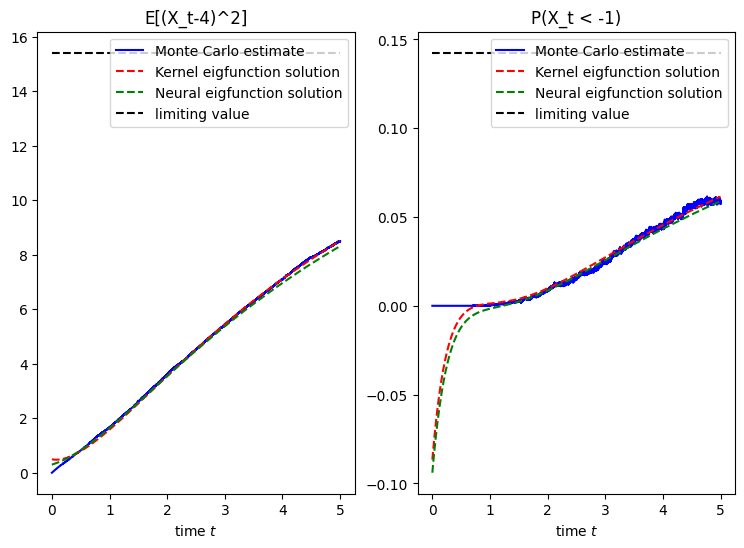

In [212]:
fig, ax = plt.subplots(1,2,figsize=(9,6))

for i, func in enumerate(funcs):
    batched_func = torch.vmap(func)
    double_batched_func = torch.vmap(batched_func)

    fsamples = double_batched_func(samples)

    mean_f = fsamples.mean(dim=1)
    limiting_value = batched_func(energy.exact_sample((100000,))).mean()
    point = torch.ones((1,1))*4
    
    fitted_kernel_sol = fitted_kernel_solver.solve(batched_func, t, point, k)[-1][0]
    fitted_neural_sol = fitted_neural_solver.solve(batched_func, t, point, k)[-1][0]

    ax[i].plot(t,mean_f, color = 'blue', label = 'Monte Carlo estimate')
    ax[i].plot(t,fitted_kernel_sol, color = 'red', label = 'Kernel eigfunction solution', ls = '--')
    ax[i].plot(t,fitted_neural_sol, color = 'green', label = 'Neural eigfunction solution', ls = '--')

    ax[i].hlines(limiting_value,0,T, color = 'black', ls = '--', label = 'limiting value')
    ax[i].set_xlabel('time $t$')
    ax[i].legend()
    ax[i].set_title(func_names[i])